In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import string
import unicodedata

!curl -fsS https://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip -o /tmp/trainDevTestTrees_PTB.zip
!unzip -q -o -d ./data /tmp/trainDevTestTrees_PTB.zip
!rm -f /tmp/trainDevTestTrees_PTB.zip

def loadsst(path):
    xs = []
    ys = []
    file1 = open(path, 'r')
    Lines = file1.readlines()
    for line in Lines:
        soup = line.split()
        ys.append(int(soup[0].lstrip('(')))
        tokens = []
        for chunk in soup[2:]:
            if not chunk.endswith(")"):
                continue
            tokens.append(chunk.rstrip(')'))
        xs.append(tokens)
    return xs, ys

ssttrainxs, ssttrainys = loadsst("./data/trees/train.txt")
sstvalidxs, sstvalidys = loadsst("./data/trees/dev.txt")
ssttestxs, ssttestys = loadsst("./data/trees/test.txt")

def normalize(s):
    for i in range(len(s)):
        replacements = [(" ,", ","), (" .", "."), (" '", "'"), 
                        ("\/", "/"), (" ;", ";"), (" :", ":"),
                        (" %", "%"), (u"æ", "ae"), (u"Æ", "AE"), 
                        (u"œ", "oe"), (u"Œ", "OE"), ("-LRB- ", "("), 
                        (" -RRB-", ")"), ("-LRB-", "("), ("-RRB-", ")"),
                        (" n't", "n't"), ("`` ", '"'), ("``", '"'),
                        ("''", '"'), ("` ", "'"), ("$ ", "$"),
                        (" !", "!"), ("\\", "")]
        for to_replace, replacement in replacements:
            s = s.replace(to_replace, replacement)
    # https://stackoverflow.com/a/518232/2809427
    def unicodeToAscii(s):
        allowed_chars = string.ascii_letters + ' .,;:\'-#!/"=&$|_'
        return ''.join(
            c for c in unicodedata.normalize('NFD', s)
            if unicodedata.category(c) != 'Mn'
            and c in allowed_chars
        )
    return unicodeToAscii(s)

def get_normalized_dataset(dataset):
    return [normalize(" ".join(sentence)) for sentence in dataset]

trainxs_corpus = "_".join(get_normalized_dataset(ssttrainxs))
validxs_corpus = "_".join(get_normalized_dataset(sstvalidxs))
testxs_corpus = "_".join(get_normalized_dataset(ssttestxs))

seq_len = 200

corpus_to_ss = lambda corpus: [corpus[(i*200):((i+1)*200)] for i in range(len(corpus) // seq_len)]
trainxs_sentences = corpus_to_ss(trainxs_corpus)

In [3]:
vocab = sorted(list(set(trainxs_corpus)))
n_sentences, vocab_size = len(trainxs_sentences), len(vocab)
maxlen = len(max(trainxs_sentences, key=len))
char_to_idx = { ch:idx for idx,ch in enumerate(vocab) }
idx_to_char = { idx:ch for idx,ch in enumerate(vocab) }
print("{} sentences, {} letters in vocab, max seq len is {}".format(n_sentences, vocab_size, maxlen))

4292 sentences, 67 letters in vocab, max seq len is 200


In [4]:
def pad_inputs(sentences, maxlen):
    for i in range(len(sentences)):
        while len(sentences[i]) < maxlen:
            sentences[i] += ' '
    return sentences
trainxs = pad_inputs(trainxs_sentences, maxlen)

In [5]:
def get_input_target(ss):
    """Get input and target from padded sentences"""
    input_ss = []
    target_ss = []
    for i in range(len(ss)):
        input_ss.append([char_to_idx[c] for c in ss[i][:-1]])
        target_ss.append([char_to_idx[c] for c in ss[i][1:]])
    return input_ss, target_ss
input_ss, target_ss = get_input_target(trainxs)

In [6]:
print(input_ss[0])
print(target_ss[0])

[33, 48, 45, 0, 31, 55, 43, 51, 0, 49, 59, 0, 44, 45, 59, 60, 49, 54, 45, 44, 0, 60, 55, 0, 42, 45, 0, 60, 48, 45, 0, 59, 60, 0, 16, 45, 54, 60, 61, 58, 65, 6, 59, 0, 54, 45, 63, 0, 2, 16, 55, 54, 41, 54, 2, 0, 41, 54, 44, 0, 60, 48, 41, 60, 0, 48, 45, 6, 59, 0, 47, 55, 49, 54, 47, 0, 60, 55, 0, 53, 41, 51, 45, 0, 41, 0, 59, 56, 52, 41, 59, 48, 0, 45, 62, 45, 54, 0, 47, 58, 45, 41, 60, 45, 58, 0, 60, 48, 41, 54, 0, 14, 58, 54, 55, 52, 44, 0, 32, 43, 48, 63, 41, 58, 66, 45, 54, 45, 47, 47, 45, 58, 7, 0, 23, 45, 41, 54, 8, 16, 52, 41, 61, 44, 0, 35, 41, 54, 0, 17, 41, 53, 53, 45, 0, 55, 58, 0, 32, 60, 45, 62, 45, 54, 0, 32, 45, 47, 41, 52, 9, 40, 33, 48, 45, 0, 47, 55, 58, 47, 45, 55, 61, 59, 52, 65, 0, 45, 52, 41, 42, 55, 58, 41, 60, 45, 0, 43, 55]
[48, 45, 0, 31, 55, 43, 51, 0, 49, 59, 0, 44, 45, 59, 60, 49, 54, 45, 44, 0, 60, 55, 0, 42, 45, 0, 60, 48, 45, 0, 59, 60, 0, 16, 45, 54, 60, 61, 58, 65, 6, 59, 0, 54, 45, 63, 0, 2, 16, 55, 54, 41, 54, 2, 0, 41, 54, 44, 0, 60, 48, 41, 60, 0, 4

In [7]:
# Hyperparameters
seq_len = maxlen - 1
batch_size = n_sentences
n_epochs = 300
lr = 0.01

In [8]:
def one_hot_encode(ss, vocab_size, seq_len, batch_size):
    tensor = torch.zeros(batch_size, seq_len, vocab_size)
    for i in range(batch_size):
        for j in range(seq_len):
            tensor[i, j, ss[i][j]] = 1
    return tensor

In [9]:
input_ohe = one_hot_encode(input_ss, vocab_size, seq_len, batch_size)
target_tensor = torch.Tensor(target_ss) # No OHE necessary

In [10]:
device = torch.device("cpu")
if torch.cuda.is_available: device = torch.device("cuda")

In [11]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, 1, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        output, nextHidden = self.rnn(input, hidden)
        output = self.fc(output)
        return output, nextHidden

    def init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size)

In [12]:
rnn = RNN(input_size=vocab_size, output_size=vocab_size, hidden_size=23)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn.parameters(), lr=lr)

In [14]:
rnn.to(device)

RNN(
  (rnn): RNN(67, 23, batch_first=True)
  (fc): Linear(in_features=23, out_features=67, bias=True)
)

In [15]:
def train(input_ohe, target_tensor, n_epochs):
    loss_ary = []
    target_tensor = target_tensor.to(device)
    input_ohe = input_ohe.to(device)
    for epoch in range(1, n_epochs + 1):
        optimizer.zero_grad()
        hidden = rnn.init_hidden(batch_size).to(device)
        output, hidden = rnn(input_ohe, hidden)
        loss = criterion(output.view(-1, vocab_size), target_tensor.view(-1).long())
        loss.backward()
        optimizer.step()
        
        if epoch%10 == 0:
            print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
            print("Loss: {:.4f}".format(loss.item()))
        loss_ary.append(loss)
    return rnn, loss_ary
rnn, loss_ary = train(input_ohe, target_tensor, n_epochs)

Epoch: 10/300............. Loss: 3.2083
Epoch: 20/300............. Loss: 3.0929
Epoch: 30/300............. Loss: 3.0290
Epoch: 40/300............. Loss: 2.9462
Epoch: 50/300............. Loss: 2.8463
Epoch: 60/300............. Loss: 2.7479
Epoch: 70/300............. Loss: 2.6624
Epoch: 80/300............. Loss: 2.5935
Epoch: 90/300............. Loss: 2.5375
Epoch: 100/300............. Loss: 2.4930
Epoch: 110/300............. Loss: 2.4596
Epoch: 120/300............. Loss: 2.4335
Epoch: 130/300............. Loss: 2.4122
Epoch: 140/300............. Loss: 2.3929
Epoch: 150/300............. Loss: 2.3773
Epoch: 160/300............. Loss: 2.3632
Epoch: 170/300............. Loss: 2.3500
Epoch: 180/300............. Loss: 2.3372
Epoch: 190/300............. Loss: 2.3249
Epoch: 200/300............. Loss: 2.3129
Epoch: 210/300............. Loss: 2.3014
Epoch: 220/300............. Loss: 2.2912
Epoch: 230/300............. Loss: 2.2795
Epoch: 240/300............. Loss: 2.2685
Epoch: 250/300...........

(1.7143075466156006, 4.33110294342041)

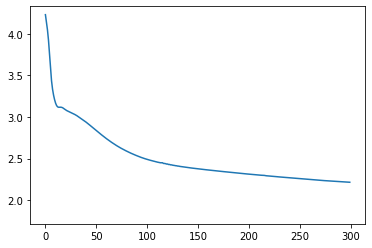

In [29]:
plt.plot(loss_ary)
plt.ylim(min(loss_ary).item()-0.5, max(loss_ary).item()+0.1)

In [17]:
def predict_one(model, s, argmax=False):
    batch_size = 1
    s_tensor = torch.tensor([char_to_idx[c] for c in s]).unsqueeze(0)
    s_ohe = one_hot_encode(s_tensor, vocab_size, s_tensor.size(1), batch_size)
    hidden = model.init_hidden(batch_size)
    out, hidden = model(s_ohe, hidden)
    prob = F.softmax(out, dim=2)
    
    last_prob = prob[0, -1]
    argmax_idx = last_prob.argmax().item()
    sample_idx = last_prob.multinomial(num_samples=1, replacement=True)
    pred_char = idx_to_char[sample_idx.item()]
    if argmax:
        pred_char = idx_to_char[argmax_idx.item()]
    
    return pred_char, hidden

In [30]:
def predict_n_from_seed(n, seed, model):
    model = model.cpu()
    output = seed
    with torch.no_grad():
        for _ in range(n - len(output)):
            c, h = predict_one(model, output)
            output += c
    return output

In [32]:
predict_n_from_seed(200, 'We all live in', rnn)

'We all live in tidg in bebathoy thy fes hoodtim Biliratat"-in in cuplliat cempithaly an the of burk steevl cusne, shimolakich oWolKe allaw to mozly ackove yur the wits aly af for aans the thikl- goke '